# Dylan

### Notes
**Ideas:**  
Split data into blocks, maybe store the data 3 dimensionally.  

**Dimensions:**  
- Location
- Block (10 sequential days)
- Day
- Weather data
  
**Test Train Split Legend:**  
Source  
[[4, 5, 1, 9],  
 [2, 9, 5, 6],  
 [9, 5, 1, 8],  
 [8, 1, 2, 7]]  
Features (X) → Target (Y)  
[[4, 5, 1]   → [[9]  
 [2, 9, 5]   →  [6]  
 [9, 5, 1]   →  [8]  
 [8, 1, 2]   →  [7]]  

### Settings

In [1]:
block_size = 10

### Imports

In [2]:
import pandas as pd
#import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
from datetime import datetime, date
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
raw_data = pd.read_csv('./weatherAUS.csv')
# Remove columns that either has a large amount of missing data or are not suitable for machine learning
raw_data.drop(columns=['Sunshine', 'Evaporation', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], inplace=True)
raw_data

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,01-12-2008,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,02-12-2008,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,03-12-2008,Albury,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2
3,04-12-2008,Albury,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5
4,05-12-2008,Albury,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4
145456,22-06-2017,Uluru,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5
145457,23-06-2017,Uluru,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1
145458,24-06-2017,Uluru,7.8,27.0,0.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0


### Date conversion

In [4]:
def to_iso_date(_date: str) -> str:
	'''Converts the date from dd-mm-yyyy to yyyy-mm-dd'''
	return datetime.strptime(_date, '%d-%m-%Y').strftime("%Y-%m-%d")

def convert_date_to_day_index(_date: str):
	'''Converts the date into the number of days since 2000-01-01'''
	delta = datetime.strptime(_date, '%Y-%m-%d').date() - date(2000, 1, 1)
	return delta.days

def extract_year(_date: str) -> int:
	'''Returns the year component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').year

def extract_month(_date: str) -> int:
	'''Returns the month component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').month

def extract_day(_date: str) -> int:
	'''Returns the day component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').day

redated = raw_data.copy()
redated['Date'] = redated['Date'].apply(to_iso_date)
redated['DayIndex'] = redated['Date'].apply(convert_date_to_day_index)
# TODO May need to remove year to prevent overfitting
redated['Year'] = redated['Date'].apply(extract_year)
redated['Month'] = redated['Date'].apply(extract_month)
# Don't include the day to make it harder for the model to overfit
#redated['Day'] = redated['Date'].apply(extract_day)
# Remove the date as well for the same reason
redated.drop(columns=['Date'], inplace=True)
redated

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,DayIndex,Year,Month
0,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,3257,2008,12
1,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,3258,2008,12
2,Albury,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,3259,2008,12
3,Albury,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,3260,2008,12
4,Albury,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,3261,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,6381,2017,6
145456,Uluru,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,6382,2017,6
145457,Uluru,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,6383,2017,6
145458,Uluru,7.8,27.0,0.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,6384,2017,6


### Reconfigure dataframe
https://pandas.pydata.org/docs/user_guide/advanced.html

In [5]:
def reconfigure(_df: pd.DataFrame, _block_size=5):
	'''Splits the rows into blocks up to a max size defined by block_size. Blocks are per location. Uses Location, Date, Block, and Id as the labels for a multiIndex DataFrame.'''
	# Lists to store block and id number
	block = []
	id = []

	# Goes through every location
	for tag, group in _df.groupby('Location'):
		block_num = 0
		id_num = 0
		prev = group['DayIndex'].iloc[0]

		# Iterate over the DayIndex column
		for idx, index_num in group['DayIndex'].items():
			# Check if a new block should be started
			if id_num == _block_size or (index_num - prev > 1):
				block_num += 1
				id_num = 0  # Reset ID within the block

			# Append the block number and ID within block to the lists
			block.append(block_num)
			id.append(id_num)

			# Update variables for the next iteration
			id_num += 1
			prev = index_num

	# Create the multiIndex
	index = pd.MultiIndex.from_arrays(
		[_df['Location'], block, id],
		names=['Location', 'Block', 'Id']
	)

	# Removed unneeded columns and apply the multiIndex
	stripped = _df.drop(columns=['Location'])
	stripped.set_index(index, inplace=True)
	return stripped

reconfigured = reconfigure(redated, block_size)
reconfigured

#locations = multi_indexed.index.get_level_values('Location').drop_duplicates().to_list()
#albury = multi_indexed.xs('Albury')

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
Location Block Id                                                            
Albury   0     0      13.4     22.9       0.6           44.0          20.0   
               1       7.4     25.1       0.0           44.0           4.0   
               2      12.9     25.7       0.0           46.0          19.0   
               3       9.2     28.0       0.0           24.0          11.0   
               4      17.5     32.3       1.0           41.0           7.0   
...                    ...      ...       ...            ...           ...   
Uluru    301   3       2.8     23.4       0.0           31.0          13.0   
               4       3.6     25.3       0.0           22.0          13.0   
               5       5.4     26.9       0.0           37.0           9.0   
               6       7.8     27.0       0.0           28.0          13.0   
               7      14.9      NaN       0.0            NaN          17.0   

                   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
Location Block Id                                                        
Albury   0     0           24.0         71.0         22.0       1007.7   
               1           22.0         44.0         25.0       1010.6   
               2           26.0         38.0         30.0       1007.6   
               3            9.0         45.0         16.0       1017.6   
               4           20.0         82.0         33.0       1010.8   
...                         ...          ...          ...          ...   
Uluru    301   3           11.0         51.0         24.0       1024.6   
               4            9.0         56.0         21.0       1023.5   
               5            9.0         53.0         24.0       1021.0   
               6            7.0         51.0         24.0       1019.4   
               7           17.0         62.0         36.0       1020.2   

                   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
Location Block Id                                                      
Albury   0     0        1007.1       8.0       NaN     16.9     21.8   
               1        1007.8       NaN       NaN     17.2     24.3   
               2        1008.7       NaN       2.0     21.0     23.2   
               3        1012.8       NaN       NaN     18.1     26.5   
               4        1006.0       7.0       8.0     17.8     29.7   
...                        ...       ...       ...      ...      ...   
Uluru    301   3        1020.3       NaN       NaN     10.1     22.4   
               4        1019.1       NaN       NaN     10.9     24.5   
               5        1016.8       NaN       NaN     12.5     26.1   
               6        1016.5       3.0       2.0     15.1     26.0   
               7        1017.9       8.0       8.0     15.0     20.9   

                   DayIndex  Year  Month  
Location Block Id                         
Albury   0     0       3257  2008     12  
               1       3258  2008     12  
               2       3259  2008     12  
               3       3260  2008     12  
               4       3261  2008     12  
...                     ...   ...    ...  
Uluru    301   3       6381  2017      6  
               4       6382  2017      6  
               5       6383  2017      6  
               6       6384  2017      6  
               7       6385  2017      6  

[145460 rows x 17 columns]

In [6]:
def purge(_df: pd.DataFrame):
	# Count rows in each block
	block_sizes = _df.groupby(['Location', 'Block']).size()

	# Ignore the error, it is mistaken
	unfit = pd.DataFrame({'size': block_sizes[block_sizes < block_size]})['size'].index.to_list()

	# Boolean indexing to drop multiple combinations
	df_filtered = _df[~((_df.index.get_level_values('Location').isin([x[0] for x in unfit])) &
                        _df.index.get_level_values('Block').isin([x[1] for x in unfit]))]

	return df_filtered

purged = purge(reconfigured)
purged

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
Location Block Id                                                            
Albury   0     0      13.4     22.9       0.6           44.0          20.0   
               1       7.4     25.1       0.0           44.0           4.0   
               2      12.9     25.7       0.0           46.0          19.0   
               3       9.2     28.0       0.0           24.0          11.0   
               4      17.5     32.3       1.0           41.0           7.0   
...                    ...      ...       ...            ...           ...   
Uluru    300   5       2.5     21.2       0.0           35.0          17.0   
               6       2.3     21.4       0.0           22.0          11.0   
               7       2.6     22.5       0.0           19.0           9.0   
               8       5.2     24.3       0.0           24.0          11.0   
               9       6.4     23.4       0.0           31.0          15.0   

                   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
Location Block Id                                                        
Albury   0     0           24.0         71.0         22.0       1007.7   
               1           22.0         44.0         25.0       1010.6   
               2           26.0         38.0         30.0       1007.6   
               3            9.0         45.0         16.0       1017.6   
               4           20.0         82.0         33.0       1010.8   
...                         ...          ...          ...          ...   
Uluru    300   5           19.0         57.0         32.0       1027.2   
               6            7.0         60.0         28.0       1026.9   
               7            7.0         59.0         24.0       1025.0   
               8           11.0         53.0         24.0       1023.8   
               9           17.0         53.0         25.0       1025.8   

                   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
Location Block Id                                                      
Albury   0     0        1007.1       8.0       NaN     16.9     21.8   
               1        1007.8       NaN       NaN     17.2     24.3   
               2        1008.7       NaN       2.0     21.0     23.2   
               3        1012.8       NaN       NaN     18.1     26.5   
               4        1006.0       7.0       8.0     17.8     29.7   
...                        ...       ...       ...      ...      ...   
Uluru    300   5        1023.0       NaN       NaN     10.3     20.3   
               6        1022.8       NaN       NaN      8.9     20.3   
               7        1021.4       NaN       NaN      8.8     22.1   
               8        1020.0       NaN       NaN     12.3     23.3   
               9        1023.0       NaN       NaN     11.2     23.1   

                   DayIndex  Year  Month  
Location Block Id                         
Albury   0     0       3257  2008     12  
               1       3258  2008     12  
               2       3259  2008     12  
               3       3260  2008     12  
               4       3261  2008     12  
...                     ...   ...    ...  
Uluru    300   5       6373  2017      6  
               6       6374  2017      6  
               7       6375  2017      6  
               8       6376  2017      6  
               9       6377  2017      6  

[126920 rows x 17 columns]

### Missing values

In [7]:
print(purged.isnull().sum())
purged.describe()

MinTemp           1295
MaxTemp           1128
Rainfall          2864
WindGustSpeed     8937
WindSpeed9am      1526
WindSpeed3pm      2622
Humidity9am       2370
Humidity3pm       3881
Pressure9am      13271
Pressure3pm      13231
Cloud9am         48791
Cloud3pm         51661
Temp9am           1576
Temp3pm           3083
DayIndex             0
Year                 0
Month                0
dtype: int64


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,DayIndex,Year,Month
count,125625.000000,125792.000000,124056.000000,117983.000000,125394.000000,124298.00000,124550.000000,123039.000000,113649.000000,113689.000000,78129.000000,75259.000000,125344.000000,123837.000000,126920.000000,126920.000000,126920.000000
mean,12.201118,23.222814,2.380002,40.100175,14.093752,18.68948,68.865050,51.547127,1017.634636,1015.244533,4.456015,4.516417,16.997931,21.687767,4850.682587,2012.791049,6.399645
std,6.399390,7.122275,8.563185,13.602429,8.928593,8.81012,19.023621,20.798019,7.112899,7.042893,2.886646,2.720185,6.482855,6.945012,914.416714,2.520769,3.437797
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.00000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2867.000000,2007.000000,1.000000
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.00000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,4042.000000,2011.000000,3.000000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.00000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,4907.000000,2013.000000,6.000000
75%,16.900000,28.200000,0.800000,48.000000,19.000000,24.00000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,5655.000000,2015.000000,9.000000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.00000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,6385.000000,2017.000000,12.000000


In [8]:
# Fill missing data
data_filled = purged.copy()
data_filled.fillna({'MinTemp': data_filled['MinTemp'].interpolate()}, inplace=True)
data_filled.fillna({'MaxTemp': data_filled['MaxTemp'].interpolate()}, inplace=True)
data_filled.fillna({'Temp9am': data_filled['Temp9am'].interpolate()}, inplace=True)
data_filled.fillna({'Temp3pm': data_filled['Temp3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Rainfall': data_filled['Rainfall'].interpolate()}, inplace=True)
data_filled.fillna({'WindGustSpeed': data_filled['WindGustSpeed'].interpolate()}, inplace=True)
data_filled.fillna({'WindSpeed9am': data_filled['WindSpeed9am'].interpolate()}, inplace=True)
data_filled.fillna({'WindSpeed3pm': data_filled['WindSpeed3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Humidity9am': data_filled['Humidity9am'].interpolate()}, inplace=True)
data_filled.fillna({'Humidity3pm': data_filled['Humidity3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Pressure9am': data_filled['Pressure9am'].interpolate()}, inplace=True)
data_filled.fillna({'Pressure3pm': data_filled['Pressure3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Cloud9am': 0}, inplace=True)
data_filled.fillna({'Cloud3pm': 0}, inplace=True)

/tmp/ipykernel_18542/3877982064.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filled.fillna({'MinTemp': data_filled['MinTemp'].interpolate()}, inplace=True)
/tmp/ipykernel_18542/3877982064.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filled.fillna({'MaxTemp': data_filled['MaxTemp'].interpolate()}, inplace=True)
/tmp/ipykernel_18542/3877982064.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filled.fillna({'Temp9am': data_filled['Temp9am'].interpolate()}, inplace=True)
/tmp/ipykernel_18542/3877982064.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filled.fillna({'Temp3pm': data_filled['Temp3pm'].interpolate()}, inplace=True)
/tmp/ipykernel_18542/3877982064.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_filled.fillna({'Rainfall': data_filled['Rainfall'].interpolate()}, inplace=True)
/tmp/ipykernel_185

In [9]:
print(data_filled.isnull().sum())
data_filled.describe()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
DayIndex         0
Year             0
Month            0
dtype: int64


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,DayIndex,Year,Month
count,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000,126920.000000
mean,12.217006,23.212568,2.456415,40.043492,14.093653,18.800772,68.891790,51.428553,1017.665605,1015.241950,2.743019,2.678073,16.973236,21.719873,4850.682587,2012.791049,6.399645
std,6.389910,7.112589,8.619758,13.277609,8.913829,8.866348,19.047453,20.764053,6.997001,6.931677,3.135000,3.051363,6.490780,6.967261,914.416714,2.520769,3.437797
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2867.000000,2007.000000,1.000000
25%,7.600000,18.000000,0.000000,31.000000,7.000000,13.000000,57.000000,36.577906,1012.962952,1010.600000,0.000000,0.000000,12.300000,16.700000,4042.000000,2011.000000,3.000000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.700000,1015.300000,1.000000,1.000000,16.700000,21.200000,4907.000000,2013.000000,6.000000
75%,16.900000,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1019.900000,6.000000,6.000000,21.500000,26.400000,5655.000000,2015.000000,9.000000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,6385.000000,2017.000000,12.000000


### Visualisation

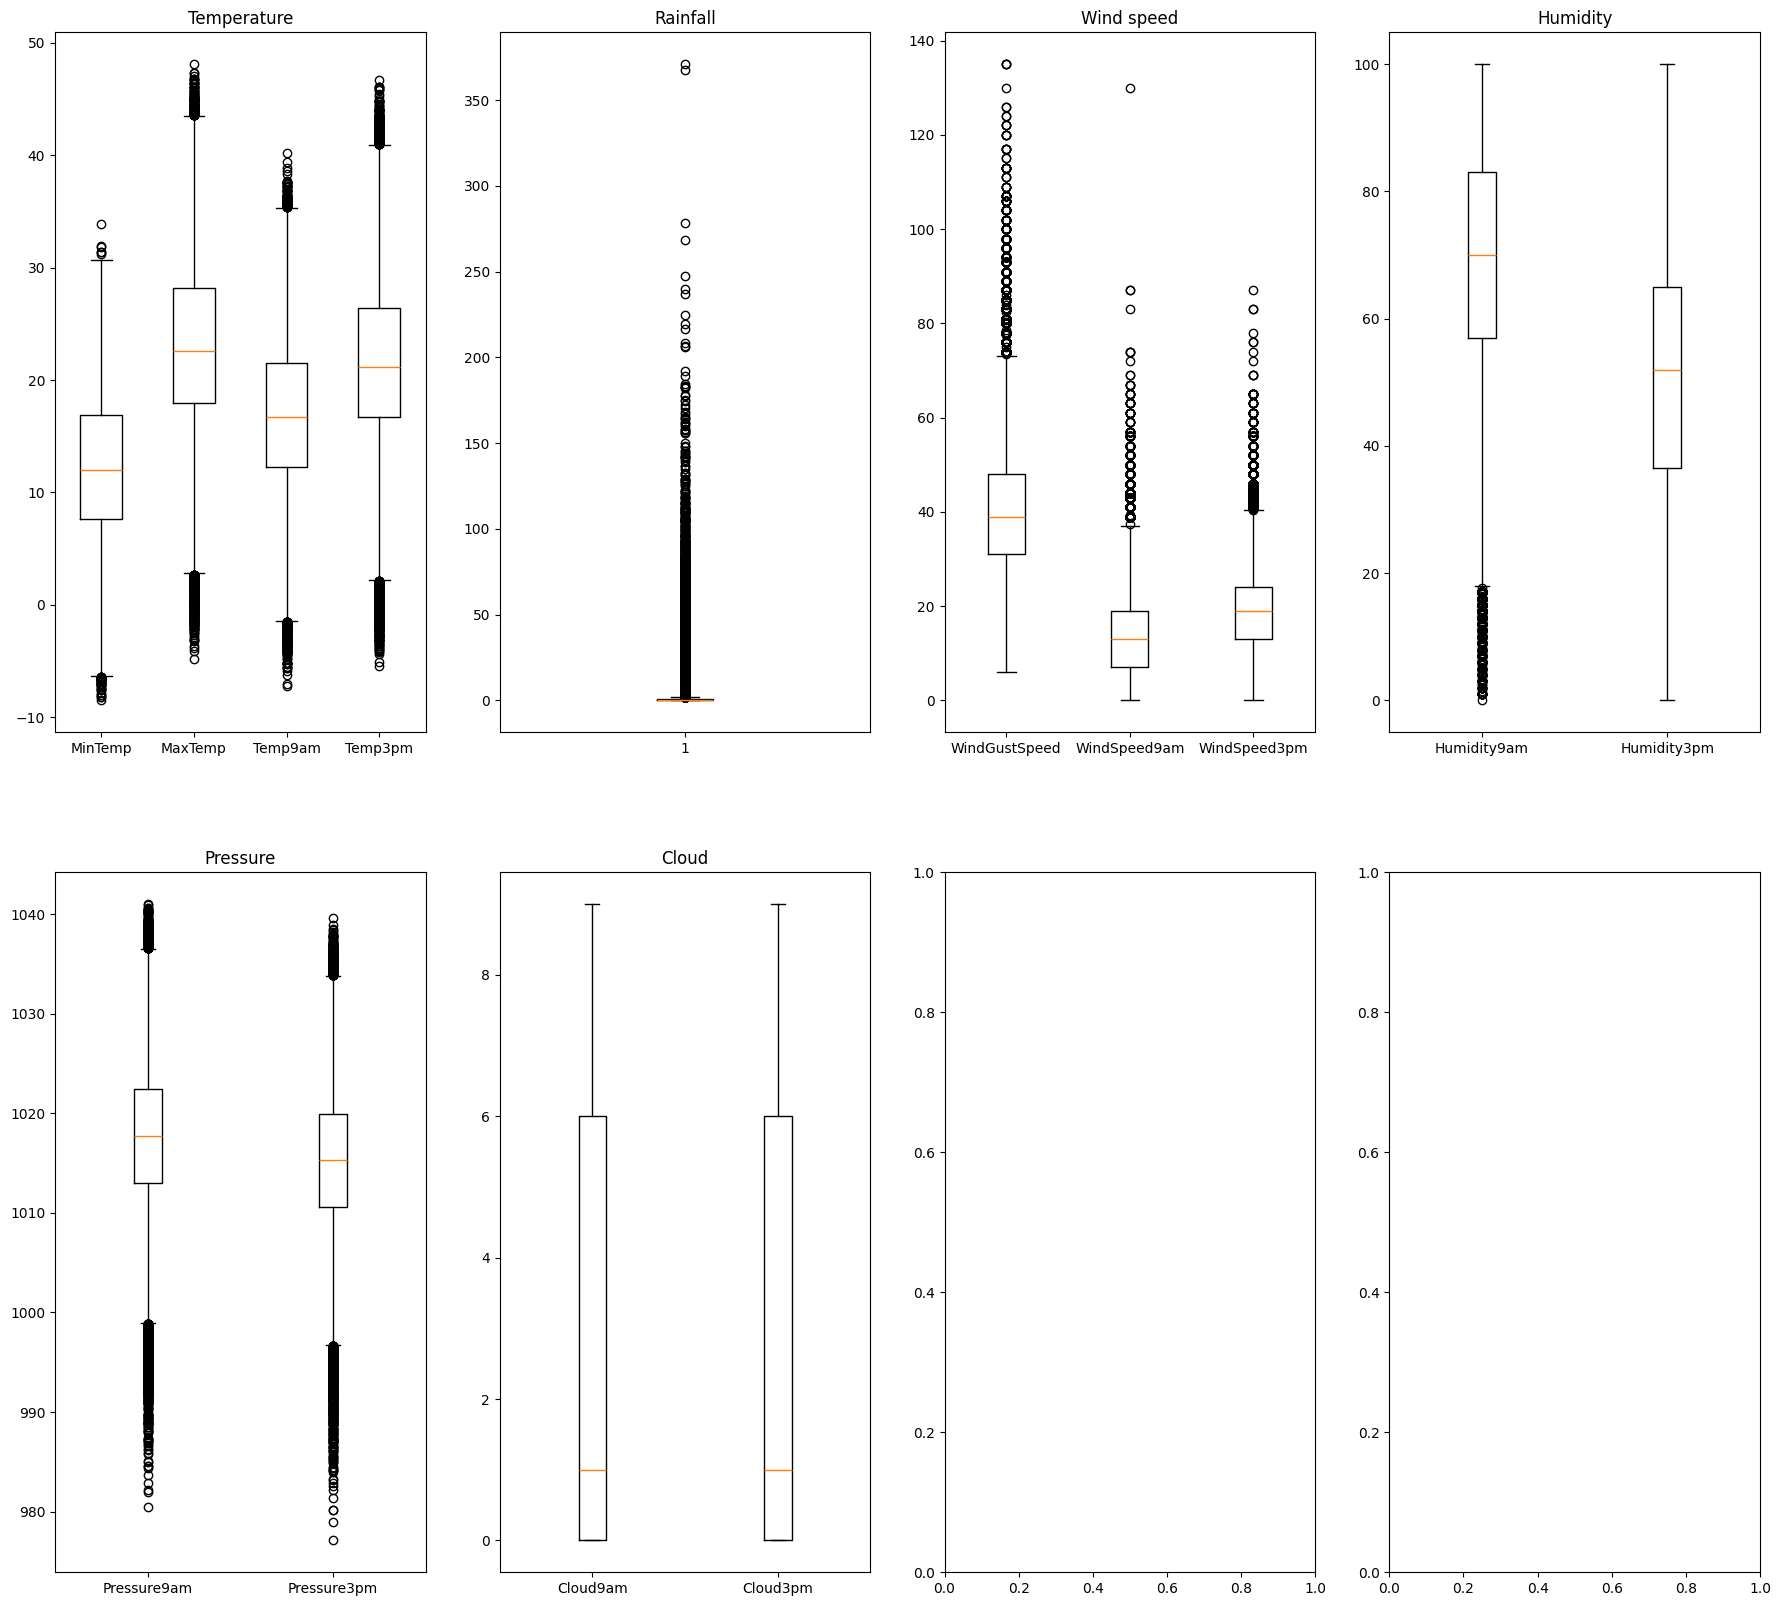

In [10]:
visualisation_data = data_filled.copy()
fig, axs = plt.subplots(2, 4, figsize=(22, 20), sharey=False)

# MinTemp MaxTemp Temp9am Temp3pm
axs[0][0].set_title('Temperature')
temperature_labels = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
temperatures = visualisation_data[temperature_labels]
axs[0][0].boxplot(temperatures, tick_labels=temperature_labels)

# Rainfall Evaporation
axs[0][1].set_title('Rainfall')
rainfall = visualisation_data['Rainfall']
axs[0][1].boxplot(rainfall)

# WindGustSpeed WindSpeed9am WindSpeed3pm
axs[0][2].set_title('Wind speed')
wind_speed_labels = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
wind_speed = visualisation_data[wind_speed_labels]
axs[0][2].boxplot(wind_speed, tick_labels=wind_speed_labels)

# Humidity9am Humidity3pm
axs[0][3].set_title('Humidity')
humidity_labels = ['Humidity9am', 'Humidity3pm']
humidity = visualisation_data[humidity_labels]
axs[0][3].boxplot(humidity, tick_labels=humidity_labels)

# Pressure9am Pressure3pm
axs[1][0].set_title('Pressure')
pressure_labels = ['Pressure9am', 'Pressure3pm']
pressure = visualisation_data[pressure_labels]
axs[1][0].boxplot(pressure, tick_labels=pressure_labels)

# Cloud9am Cloud3pm
axs[1][1].set_title('Cloud')
cloud_labels = ['Cloud9am', 'Cloud3pm']
cloud = visualisation_data[cloud_labels]
axs[1][1].boxplot(cloud, tick_labels=cloud_labels)

## Year Location
#axs[1][2].set_title('Year range per location')
#axs[1][2].scatter(visualisation_data['Year'], visualisation_data['Location'])

## Month Day
#axs[1][3].set_title('Total day range per location')
#date = visualisation_data['Year'] * 353 + (visualisation_data['Month'] - 1) * 32 + visualisation_data['Day']
#axs[1][3].scatter(date, visualisation_data['Location'])

plt.show()

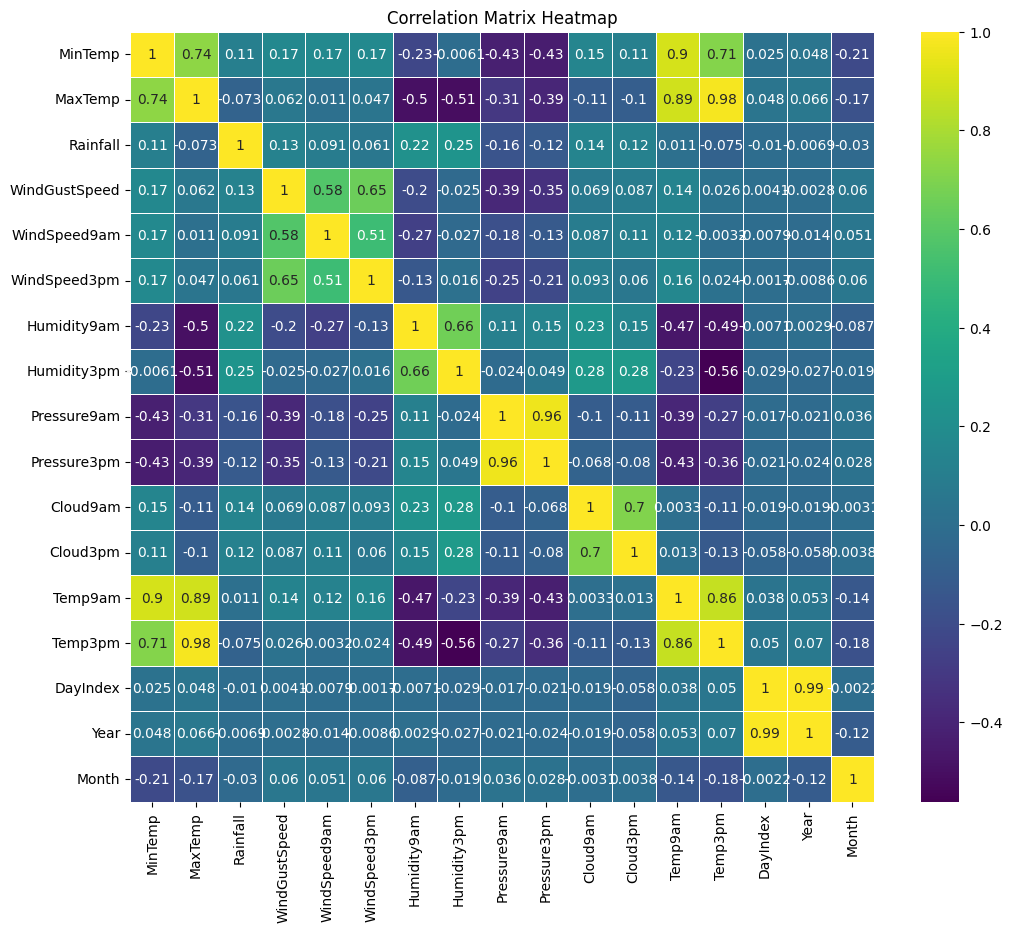

In [11]:
plt.figure(figsize=(12, 10))
corr_matrix = data_filled.corr()
sb.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Training

I guess I'm going to have to restructure the table so the feature rows have (block_size-1) times as many columns in them containing (block_size-1) days worth of data.

Create training, validation, and test data

In [18]:
# These two need to be the same size
X = data_filled[data_filled.index.get_level_values('Id') != block_size - 1] # Features
Y = data_filled[data_filled.index.get_level_values('Id') == block_size - 1] # Target

if X.shape[0] != Y.shape[0]:
	print(f'Mismatch found: X has {X.shape[0]} samples, Y has {Y.shape[0]} samples.')
	#Y = Y[:X.shape[0]]

pca = decomp.PCA(n_components=Y.shape[0])
X_reduced = pca.fit_transform(X)

print(f'X_reduced has {X_reduced.shape[0]} samples, Y has {Y.shape[0]} samples.')

#X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
## Note: 0.25 x 0.8 = 0.2, so the validation set is 20% of the original dataset
#X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)
#print(f"Training set size: {X_train.shape[0]} samples")
#print(f"Validation set size: {X_val.shape[0]} samples")
#print(f"Test set size: {X_test.shape[0]} samples")

# Flatten the DataFrame to use for machine learning
#groups = data_filled.index.get_level_values('Block')  # Use Block as the group identifier
#print(groups)

gkf = GroupKFold(n_splits=5)

#for train_index, test_index in gkf.split(X_reduced, Y, groups=groups):
#	print("\nTRAIN:", train_index, "TEST:", test_index)
#	X_train, X_test = X[train_index], X[test_index]
#	y_train, y_test = Y[train_index], Y[test_index]

Mismatch found: X has 114228 samples, Y has 12692 samples.


ValueError: n_components=12692 must be between 0 and min(n_samples, n_features)=17 with svd_solver='covariance_eigh'